In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime, timedelta
from dateparser import parse
import re
from sklearn.pipeline import Pipeline
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD 
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor
import shap
from sklearn.metrics import r2_score
from sklearn.base import clone
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import scipy.cluster.hierarchy as sch

In [2]:
# Load data
tweet_data = pd.read_csv("Prabowo_All2.csv", delimiter='\t', header=None, names=['data'])
tweet_data = tweet_data['data'].str.split(';', expand=True)
tweet_data.columns = ['created_at', 'id_str', 'full_text', 'quote_count', 'reply_count',
                      'retweet_count', 'favorite_count', 'lang', 'user_id_str',
                      'conversation_id_str', 'username', 'tweet_url']

# Function for text preprocessing
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove special characters and numbers, keep only letters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove stopwords
    stopword_factory = StopWordRemoverFactory()
    stopword_remover = stopword_factory.create_stop_word_remover()
    text = stopword_remover.remove(text)
    
    return text

# Apply text preprocessing to your data
tweet_data['cleaned_full_text'] = tweet_data['full_text'].astype(str).apply(preprocess_text)

# Load survey data
survey_data = pd.read_excel('Electionforcode_Prabowo3.xlsx')
tweet_data['date'] = pd.to_datetime(tweet_data['created_at'], format='%a %b %d %H:%M:%S +0000 %Y', errors='coerce')
tweet_data = tweet_data.dropna(subset=['date'])

# Extract the 'Numbers of Candidate' column
numbers_of_candidate = survey_data['Numbers of Candidate']

# Assuming the "Polling firm" column exists in your survey data
survey_data['Polling firm'] = survey_data['Polling firm'].astype(str)

# Perform one-hot encoding on the "Polling firm" column
survey_data = pd.get_dummies(survey_data, columns=['Polling firm'], prefix='polling')

def preprocess_text_eng(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove special characters and numbers, keep only letters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()

    # Remove English stopwords
    english_stopwords = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in english_stopwords]
    text = ' '.join(filtered_words)
    
    return text

file_data = pd.read_excel('Phenomena2.xlsx')
file_data['cleaned_Phenomenon'] = file_data['Phenomenon'].astype(str).apply(preprocess_text_eng)
file_data['date'] = pd.to_datetime(file_data['Date'], format='%a %b %d %H:%M:%S +0000 %Y', errors='coerce')
file_data = file_data.dropna(subset=['date'])

# Create lists of feature names for each type of feature
word2vec_tweet_features = ["word2vec_tweet_" + str(i) for i in range(100)]
word2vec_event_features = ["word2vec_event_" + str(i) for i in range(100)]
polling_firm_feature_names = ["polling_firm_" + str(i) for i in range(len(survey_data.filter(like='polling_').columns))]
numerical_feature_names = ["number_of_candidates"]

# Concatenate feature names before combining features
all_feature_names = (
    word2vec_tweet_features
    + word2vec_event_features
    + polling_firm_feature_names
    + numerical_feature_names
)

In [3]:
survey_data['year'] = survey_data['Date Range'].apply(lambda x: parse(x.split('-')[0]).year)
file_data['year'] = file_data['Date'].dt.year

In [5]:
# Create an empty list to store the feature names for each survey result
survey_result_feature_names = []
# Prepare features (X) and target (y)
survey_results = []  # To store survey data

In [ ]:
# Create subsets for each year in file_data
for year in range(2020, 2024):  
    file_data_yearly = file_data[file_data['year'] == year]
    survey_data_yearly = survey_data[survey_data['year'] == year] 
    
    # Check if there is any data for the current year
    if len(file_data_yearly) == 0 or len(survey_data_yearly) == 0:
        print(f"No data for year {year}. Skipping...")
        continue
    
    survey_results_yearly = []
    survey_result_feature_names_yearly = []
    # Create a loop to process survey data and perform Word2Vec with an additional Events feature
    for index, row in survey_data_yearly.iterrows():
        # Define the date range from your survey data and process it
        date_range = row['Date Range']
        date_parts = date_range.split('-')
        start_date_str = date_parts[0].strip()
        end_date_str = date_parts[1].strip()
        start_date = parse(start_date_str)
        end_date = parse(end_date_str)
    
        # Define the tweet date range
        tweet_start_date = start_date - timedelta(days=7)
        tweet_end_date = end_date + timedelta(days=7)
    
        # Filter tweets within the date range
        tweets_in_interval = tweet_data[(tweet_data['date'] >= tweet_start_date) & (tweet_data['date'] <= tweet_end_date)]
 
        # Extract cleaned text as a list
        cleaned_texts = tweets_in_interval['cleaned_full_text'].astype(str).tolist()
    
        # Create a list of tokenized sentences for tweets
        tokenized_sentences_tweets = [word_tokenize(text) for text in cleaned_texts]

        # Train Word2Vec model for tweets
        word2vec_model_tweets = Word2Vec(tokenized_sentences_tweets, vector_size=100, window=5, min_count=1, sg=0)
    
        # Create document vectors by averaging the word vectors for tweets
        document_vectors_tweets = []
        for sentence in tokenized_sentences_tweets:
            word_vectors = [word2vec_model_tweets.wv[word] for word in sentence if word in word2vec_model_tweets.wv]
            if word_vectors:
                doc_vector = np.mean(word_vectors, axis=0)
                document_vectors_tweets.append(doc_vector)
            else:
                # If no word vectors found in a sentence, add a zero vector
                document_vectors_tweets.append(np.zeros(100))

        # Calculate the average Word2Vec vector for the tweets in the interval
        avg_word2vec_tweets = np.mean(document_vectors_tweets, axis=0)
    
        # Get the one-hot encoded features for the "Polling firm"
        polling_firm_features = row.filter(like='polling_').values
    
        # Get the 'Numbers of Candidate' feature
        numbers_of_candidate_value = row['Numbers of Candidate']

        # Define the date range for Events
        event_start_date = start_date - timedelta(days=17)
        event_end_date = end_date 
    
        # Filter Events within the date range
        events_in_interval = file_data[(file_data['date'] >= event_start_date) & (file_data['date'] <= event_end_date)]
    
        # Extract cleaned text as a list for Events
        cleaned_events = events_in_interval['cleaned_Phenomenon'].astype(str).tolist()
    
        # Create a list of tokenized sentences for Events
        tokenized_sentences_events = [word_tokenize(text) for text in cleaned_events]

        # Train Word2Vec model for Events
        word2vec_model_events = Word2Vec(tokenized_sentences_events, vector_size=100, window=5, min_count=1, sg=0)
    
        # Create document vectors by averaging the word vectors for Events
        document_vectors_events = []
        for sentence in tokenized_sentences_events:
            word_vectors = [word2vec_model_events.wv[word] for word in sentence if word in word2vec_model_events.wv]
            if word_vectors:
                doc_vector = np.mean(word_vectors, axis=0)
                document_vectors_events.append(doc_vector)
            else:
                # If no word vectors found in a sentence, add a zero vector
                document_vectors_events.append(np.zeros(100))

        # Calculate the average Word2Vec vector for the Events in the interval
        avg_word2vec_events = np.mean(document_vectors_events, axis=0)
    
        # Combine Word2Vec features for tweets and Events, along with polling firm features and the number of candidates
        combined_features = np.hstack(
            (avg_word2vec_tweets, avg_word2vec_events, polling_firm_features, [numbers_of_candidate_value])
        )
    
        # Append the feature names to the list
        feature_names_for_result = (
            word2vec_tweet_features
            + word2vec_event_features
            + polling_firm_feature_names
            + numerical_feature_names
        )
        survey_result_feature_names_yearly.append(feature_names_for_result)
        survey_results_yearly.append(combined_features)
    
    # Extend the main lists with the yearly results and feature names
    survey_results.extend(survey_results_yearly)
    survey_result_feature_names.extend(survey_result_feature_names_yearly)

    # Create a DataFrame for survey results with feature names as columns
    survey_results_df = pd.DataFrame(survey_results, columns=all_feature_names)
    survey_result_feature_names_df = pd.DataFrame(survey_result_feature_names, columns=all_feature_names)
    
    # Convert the results to NumPy arrays for the current year
    X = np.array(survey_results_yearly)
    y = survey_data_yearly['Prabowo'].values.astype(float)
    
    # Define the number of splits for time series cross-validation
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    # Initialize lists to store predictions for each fold
    y_pred_rf = []
    y_true = []  # Initialize a list to store true target value
    # Perform time series cross-validation
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Create separate pipelines for each model
        pipeline_rf = Pipeline([
            ('rf', RandomForestRegressor(n_estimators=110, max_depth=10, random_state=42))  
        ])
    
        # Hyperparameter tuning for Random Forest
        param_grid_rf = {
            'rf__n_estimators': [100, 150, 200],
            'rf__max_depth': [5, 10, 15]
        }
    
        grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=tscv)
        grid_search_rf.fit(X_train, y_train)

        # Predict for the current fold
        y_pred_rf_fold = grid_search_rf.predict(X_test)

        # Append the predictions to the lists
        y_pred_rf.extend(y_pred_rf_fold)
        y_true.extend(y_test)  # Append true target values
    
    # Convert the prediction lists to NumPy arrays
    y_pred_rf = np.array(y_pred_rf)
    y_true = np.array(y_true)

    # Fit the grid search to the entire dataset
    grid_search_rf.fit(X, y)

    # Get the best estimator from the grid search
    best_rf_estimator = grid_search_rf.best_estimator_

    # Get feature importances from the best estimator
    feature_importances = best_rf_estimator.named_steps['rf'].feature_importances_

    k = 10
    top_k_features = np.argsort(-feature_importances)[:k]
    

    # Translate the top-k features back into their original word representations
    top_k_words = []

    for feature_index in top_k_features:
        if feature_index < 100:
            word = word2vec_model_tweets.wv.index_to_key[feature_index]
            top_k_words.append(f'word2vec_tweet_{word}')
        elif 100 <= feature_index < 200 and feature_index - 100 < len(word2vec_model_events.wv.index_to_key):
            word = word2vec_model_events.wv.index_to_key[feature_index - 100]
            top_k_words.append(f'word2vec_event_{word}')
        elif 200 <= feature_index < 200 + len(polling_firm_feature_names):
            word = polling_firm_feature_names[feature_index - 200]
            top_k_words.append(word)
        else:
            top_k_words.append('number_of_candidates')

    print(f"Top-{k} most important features:")
    print(top_k_words)

    # Plot the top-k important features
    plt.figure(figsize=(10, 6))
    plt.barh(range(k), feature_importances[top_k_features], align='center')
    plt.yticks(range(k), top_k_words)
    plt.xlabel('Feature Importance')
    plt.title(f"Top {k} Important Words for {year}")
    plt.show()

R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is n

In [3]:
# Create an empty list to store the feature names for each survey result
survey_result_feature_names = []
# Prepare features (X) and target (y)
survey_results = []  # To store survey data
# Create a loop to process survey data and perform Word2Vec with an additional Events feature
for index, row in survey_data.iterrows():
    # Define the date range from your survey data and process it
    date_range = row['Date Range']
    date_parts = date_range.split('-')
    start_date_str = date_parts[0].strip()
    end_date_str = date_parts[1].strip()
    start_date = parse(start_date_str)
    end_date = parse(end_date_str)
    
    # Define the tweet date range
    tweet_start_date = start_date - timedelta(days=7)
    tweet_end_date = end_date + timedelta(days=7)
    
    # Filter tweets within the date range
    tweets_in_interval = tweet_data[(tweet_data['date'] >= tweet_start_date) & (tweet_data['date'] <= tweet_end_date)]
 
    # Extract cleaned text as a list
    cleaned_texts = tweets_in_interval['cleaned_full_text'].astype(str).tolist()
    
    # Create a list of tokenized sentences for tweets
    tokenized_sentences_tweets = [word_tokenize(text) for text in cleaned_texts]

    # Train Word2Vec model for tweets
    word2vec_model_tweets = Word2Vec(tokenized_sentences_tweets, vector_size=100, window=5, min_count=1, sg=0)
    
    # Create document vectors by averaging the word vectors for tweets
    document_vectors_tweets = []
    for sentence in tokenized_sentences_tweets:
        word_vectors = [word2vec_model_tweets.wv[word] for word in sentence if word in word2vec_model_tweets.wv]
        if word_vectors:
            doc_vector = np.mean(word_vectors, axis=0)
            document_vectors_tweets.append(doc_vector)
        else:
            # If no word vectors found in a sentence, add a zero vector
            document_vectors_tweets.append(np.zeros(100))

    # Calculate the average Word2Vec vector for the tweets in the interval
    avg_word2vec_tweets = np.mean(document_vectors_tweets, axis=0)
    
    # Get the one-hot encoded features for the "Polling firm"
    polling_firm_features = row.filter(like='polling_').values
    
    # Get the 'Numbers of Candidate' feature
    numbers_of_candidate_value = row['Numbers of Candidate']

    # Define the date range for Events
    event_start_date = start_date - timedelta(days=17)
    event_end_date = end_date 
    
    # Filter Events within the date range
    events_in_interval = file_data[(file_data['date'] >= event_start_date) & (file_data['date'] <= event_end_date)]
    
    # Extract cleaned text as a list for Events
    cleaned_events = events_in_interval['cleaned_Phenomenon'].astype(str).tolist()
    
    # Create a list of tokenized sentences for Events
    tokenized_sentences_events = [word_tokenize(text) for text in cleaned_events]

    # Train Word2Vec model for Events
    word2vec_model_events = Word2Vec(tokenized_sentences_events, vector_size=100, window=5, min_count=1, sg=0)
    
    # Create document vectors by averaging the word vectors for Events
    document_vectors_events = []
    for sentence in tokenized_sentences_events:
        word_vectors = [word2vec_model_events.wv[word] for word in sentence if word in word2vec_model_events.wv]
        if word_vectors:
            doc_vector = np.mean(word_vectors, axis=0)
            document_vectors_events.append(doc_vector)
        else:
            # If no word vectors found in a sentence, add a zero vector
            document_vectors_events.append(np.zeros(100))

    # Calculate the average Word2Vec vector for the Events in the interval
    avg_word2vec_events = np.mean(document_vectors_events, axis=0)
    
    # Combine Word2Vec features for tweets and Events, along with polling firm features and the number of candidates
    combined_features = np.hstack(
        (avg_word2vec_tweets, avg_word2vec_events, polling_firm_features, [numbers_of_candidate_value])
    )
    
    # Append the feature names to the list
    feature_names_for_result = (
        word2vec_tweet_features
        + word2vec_event_features
        + polling_firm_feature_names
        + numerical_feature_names
    )
    survey_result_feature_names.append(feature_names_for_result)

    # Append the results to the list
    survey_results.append(combined_features)

# Create a DataFrame for survey results with feature names as columns
survey_results_df = pd.DataFrame(survey_results, columns=all_feature_names)
survey_result_feature_names_df = pd.DataFrame(survey_result_feature_names, columns=all_feature_names)
    

In [4]:
# Convert the results to NumPy arrays
X = np.array(survey_results)

In [5]:
# Extract the target variable from survey results
y = survey_data['Prabowo'].values.astype(float)

Top-20 most important features:
['number_of_candidates', 'word2vec_event_committee', 'word2vec_tweet_mk', 'number_of_candidates', 'word2vec_tweet_dgn', 'word2vec_tweet_kalau', 'number_of_candidates', 'word2vec_event_mayor', 'word2vec_tweet_md', 'word2vec_event_may', 'word2vec_event_bali', 'word2vec_tweet_depan', 'number_of_candidates', 'word2vec_event_emergency', 'word2vec_event_vice', 'word2vec_tweet_mahfud', 'word2vec_event_indonesia', 'word2vec_tweet_kalo', 'word2vec_event_presidential', 'word2vec_tweet_gugatan']


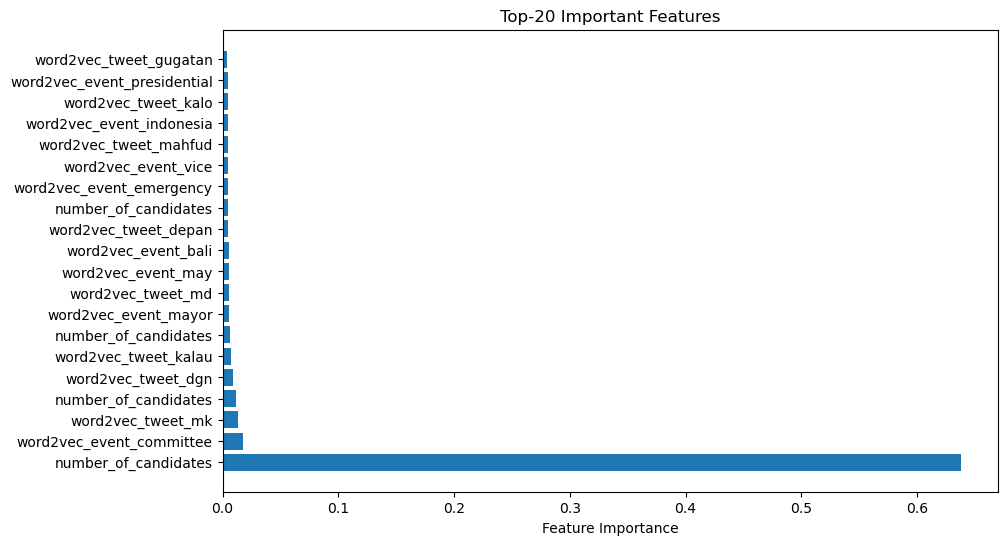

In [13]:
rf_model = RandomForestRegressor(n_estimators=110, max_depth=10, random_state=42)
rf_model.fit(X, y)

feature_importances = rf_model.feature_importances_
k = 20
top_k_features = np.argsort(-feature_importances)[:k]

# Translate the top-k features back into their original word representations
top_k_words = []

for feature_index in top_k_features:
    if feature_index < 100:
        word = word2vec_model_tweets.wv.index_to_key[feature_index]
        top_k_words.append(f'word2vec_tweet_{word}')
    elif 100 <= feature_index < 200 and feature_index - 100 < len(word2vec_model_events.wv.index_to_key):
        word = word2vec_model_events.wv.index_to_key[feature_index - 100]
        top_k_words.append(f'word2vec_event_{word}')
    elif 200 <= feature_index < 200 + len(polling_firm_feature_names):
        word = polling_firm_feature_names[feature_index - 200]
        top_k_words.append(word)
    else:
        top_k_words.append('number_of_candidates')

print(f"Top-{k} most important features:")
print(top_k_words)

# Plot the top-k important features
plt.figure(figsize=(10, 6))
plt.barh(range(k), feature_importances[top_k_features], align='center')
plt.yticks(range(k), top_k_words)
plt.xlabel('Feature Importance')
plt.title(f'Top-{k} Important Features')
plt.show()

Top 5 Important Features:
number_of_candidates: 0.6377020070808054
word2vec_event_36: 0.017891680966802156
word2vec_tweet_16: 0.013147823605359465
word2vec_event_87: 0.011353883224719868
word2vec_tweet_26: 0.00890438853422206


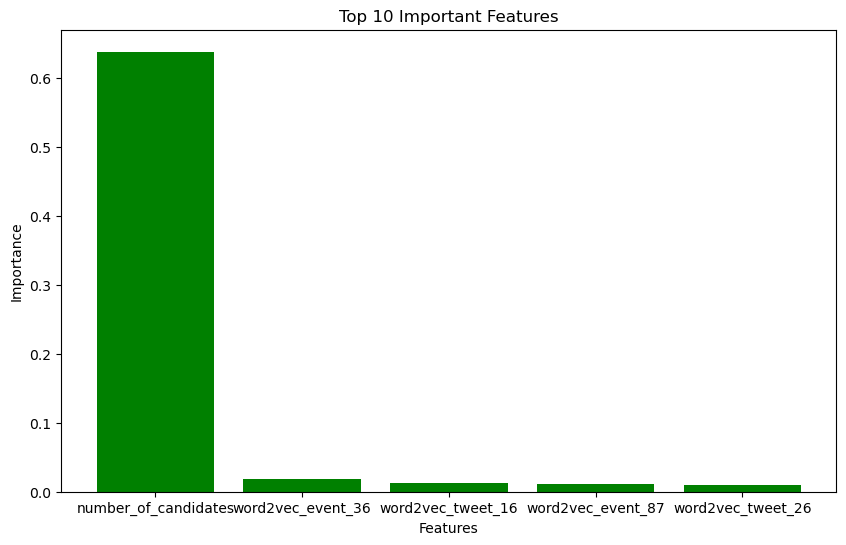

In [8]:
# Create your own RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=110, max_depth=10, random_state=42)

# Train RandomForestRegressor on the entire dataset
rf_model.fit(X, y)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a dictionary mapping feature names to importances
feature_importance_dict = dict(zip(all_feature_names, feature_importances))

# Display top N important words
top_n = 5
top_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
print(f"Top {top_n} Important Features:")
for feature, importance in top_features:
    print(f"{feature}: {importance}")

# Extract top N features and importances
top_features, top_importances = zip(*top_features)

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_features, top_importances, color='green')
plt.title('Top 10 Important Features')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [9]:
# Define the number of splits for time series cross-validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

In [10]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'svd__n_components': [10, 20, 30, 40, 50, 60],  
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [10, 20, 30]
}

# Create a pipeline with TruncatedSVD and RandomForestRegressor
pipeline_rf = Pipeline([
    ('svd', TruncatedSVD()),
    ('rf', RandomForestRegressor())
])

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=tscv, scoring='neg_mean_squared_error')

# Fit the model with hyperparameter tuning
grid_search_rf.fit(X, y)

# Get the best parameters and the best estimator
best_params_rf = grid_search_rf.best_params_
best_estimator_rf = grid_search_rf.best_estimator_

# Print the best parameters
print("Best Parameters for Random Forest:", best_params_rf)

Best Parameters for Random Forest: {'rf__max_depth': 10, 'rf__n_estimators': 150, 'svd__n_components': 10}


In [11]:
# Initialize lists to store predictions for each fold
y_pred_rf = []
y_true = []  # Initialize a list to store true target value
feature_importances_rf_list = []

# Perform time series cross-validation
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Create separate pipelines for each model
    pipeline_rf = Pipeline([
        ('svd', TruncatedSVD(n_components=best_params_rf['svd__n_components'])), 
        ('rf', RandomForestRegressor(n_estimators=best_params_rf['rf__n_estimators'],
                                     max_depth=best_params_rf['rf__max_depth'],
                                     random_state=42))  
    ])

    # Fit the model
    pipeline_rf.fit(X_train, y_train)

    # Predict for the current fold
    y_pred_rf_fold = pipeline_rf.predict(X_test)

    # Append the predictions to the lists
    y_pred_rf.extend(y_pred_rf_fold)
    y_true.extend(y_test)  # Append true target values
    
    # Access feature importances
    feature_importances_rf = pipeline_rf.named_steps['rf'].feature_importances_
    feature_importances_rf_list.append(feature_importances_rf)

# Convert the prediction lists to NumPy arrays
y_pred_rf = np.array(y_pred_rf)
y_true = np.array(y_true)

# Calculate MAE, MSE, and R2 for the Random Forest model
mae_rf = mean_absolute_error(y_true, y_pred_rf)
mse_rf = mean_squared_error(y_true, y_pred_rf)
r2_rf = r2_score(y_true, y_pred_rf)

# Print the evaluation metrics
print("MAE (Random Forest):", mae_rf)
print("MSE (Random Forest):", mse_rf)
print("R2 Score (Random Forest):", r2_rf)

MAE (Random Forest): 0.04911931764097153
MSE (Random Forest): 0.003652929093062497
R2 Score (Random Forest): 0.4349086245717311


<Figure size 1000x800 with 0 Axes>

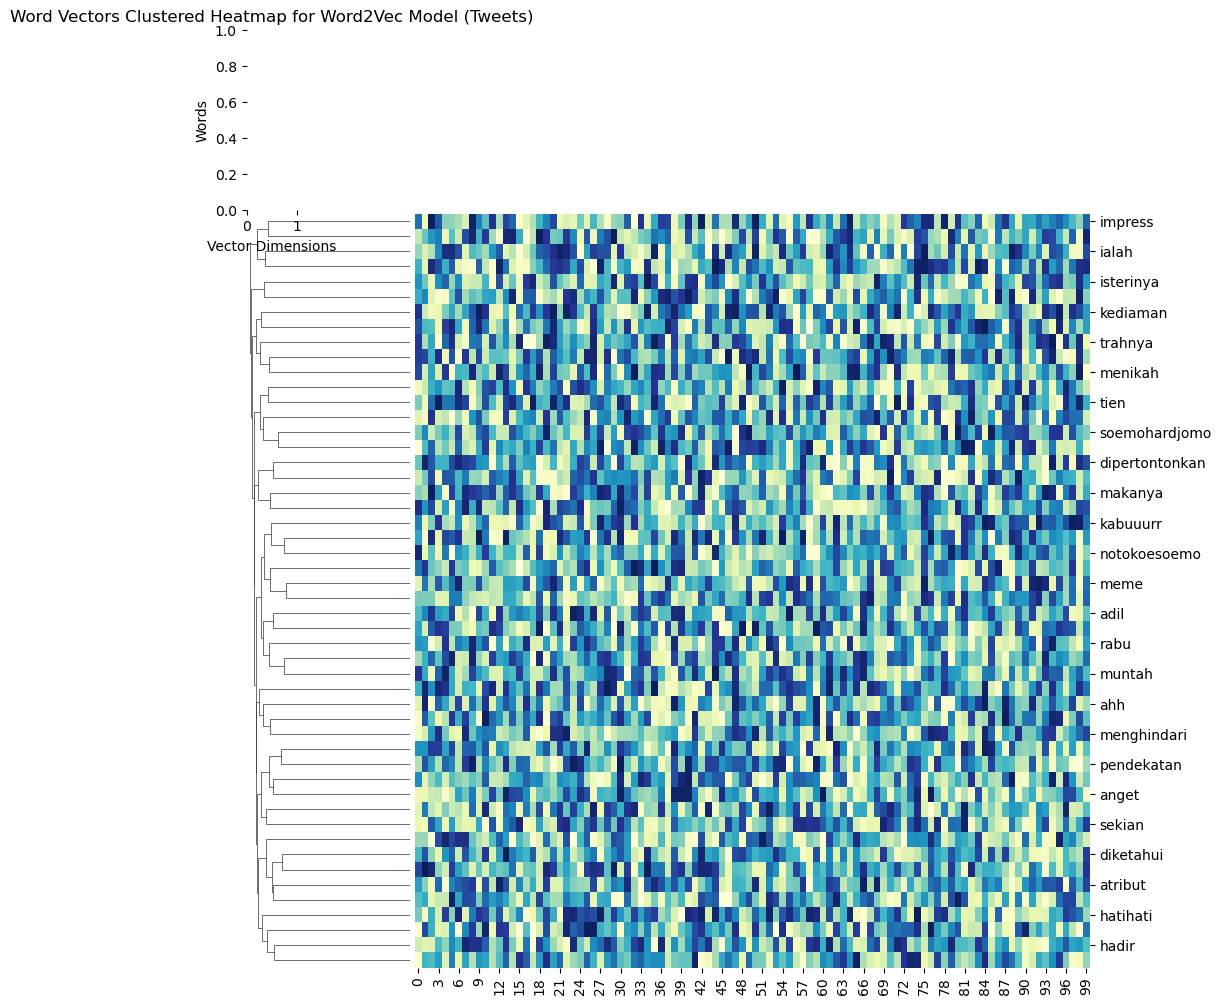

In [21]:
def plot_word_vectors_heatmap(word2vec_model, vocab, top_n=50):
    # Get the most frequent words based on their counts in the model
    sorted_vocab = sorted(vocab, key=lambda word: word2vec_model.wv.key_to_index[word], reverse=True)[:top_n]

    # Extract word vectors for the most frequent words
    word_vectors = [word2vec_model.wv.get_vector(word) for word in sorted_vocab]

    # Create a DataFrame for the word vectors
    word_vectors_df = pd.DataFrame(word_vectors, index=sorted_vocab)

    # Create a clustered heatmap
    plt.figure(figsize=(10, 8))
    sns.clustermap(word_vectors_df, cmap="YlGnBu", method="average", col_cluster=False, row_cluster=True, cbar=False)
    plt.title("Word Vectors Clustered Heatmap for Word2Vec Model (Tweets)")
    plt.xlabel("Vector Dimensions")
    plt.ylabel("Words")
    plt.show()

# Assuming you have the vocabulary (list of words) from the Word2Vec model
vocab = list(word2vec_model_tweets.wv.index_to_key)
plot_word_vectors_heatmap(word2vec_model_tweets, vocab, top_n=50)

Word2Vec Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


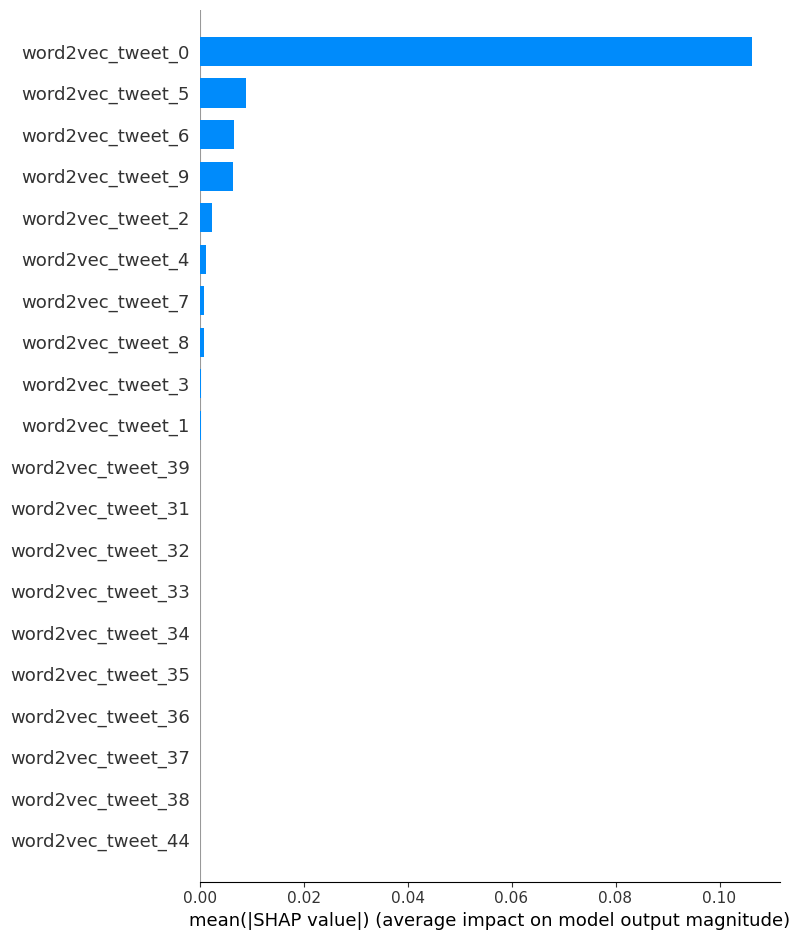

In [9]:
# Create a SHAP explainer for Random Forest
explainer_rf = shap.Explainer(pipeline_rf.named_steps['rf'])

# Get the index of Word2Vec features in the all_feature_names list
word2vec_indices = [all_feature_names.index(feature) for feature in word2vec_tweet_features]

# Double-check the indices
print("Word2Vec Indices:", word2vec_indices)

# Calculate SHAP values for Word2Vec features
shap_values_rf_word2vec = explainer_rf.shap_values(X_test[:, word2vec_indices])

# Summary plot
shap.summary_plot(shap_values_rf_word2vec, X_test[:, word2vec_indices], feature_names=word2vec_tweet_features, plot_type="bar")

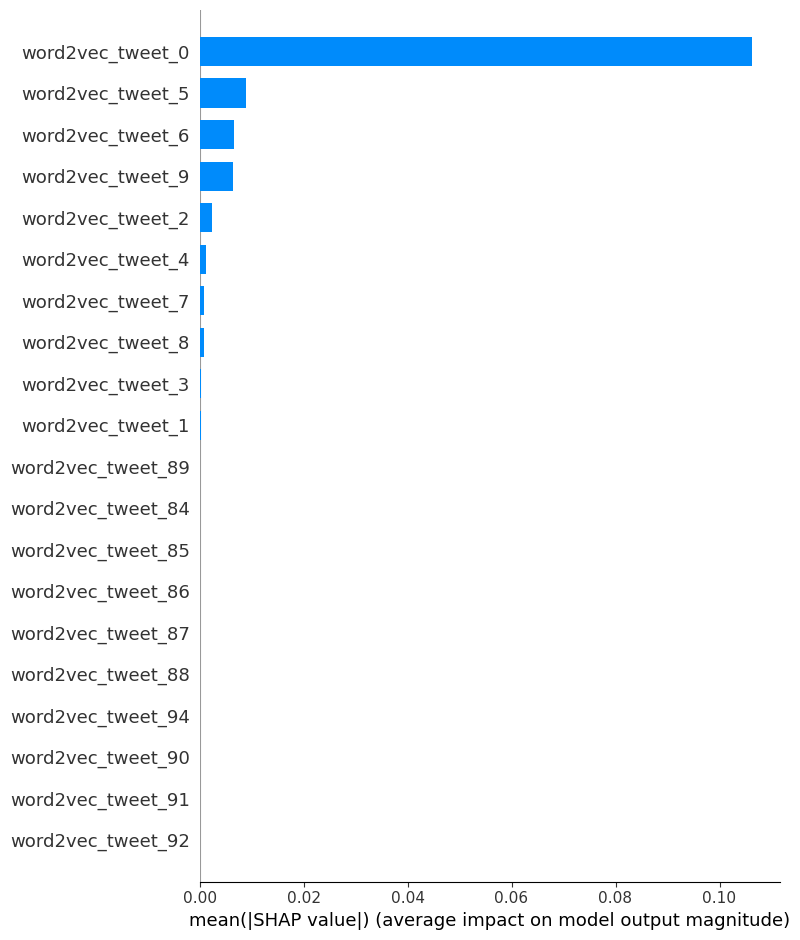

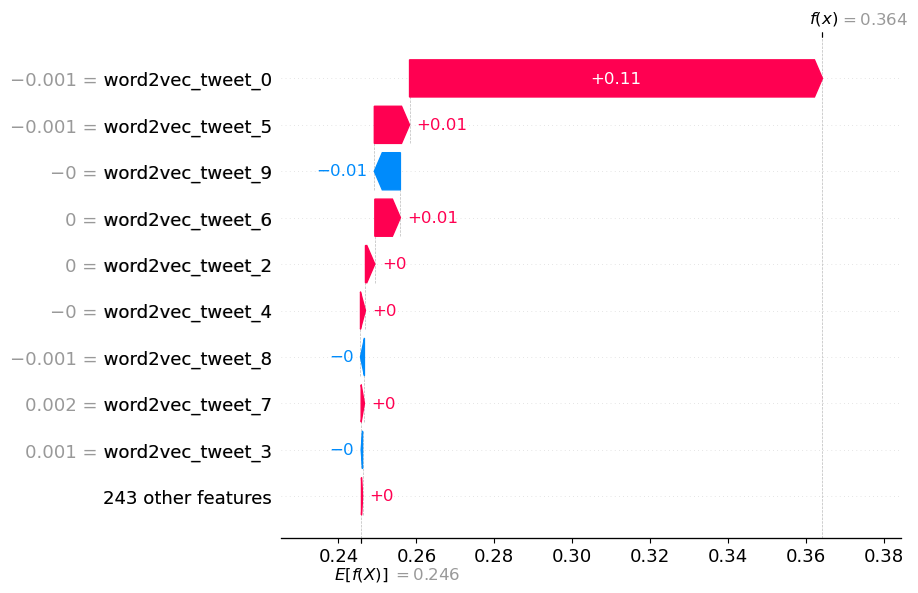

In [10]:
# Function to plot SHAP summary plot
def plot_shap_summary(shap_values, feature_names):
    shap.summary_plot(shap_values, X_test, feature_names=feature_names,plot_type="bar")

def explain_model(pipeline, X_test, feature_names, instance_index=0):
    model_name = list(pipeline.named_steps.keys())[-1]  # Get the last step's name
    model = pipeline.named_steps[model_name]
    
    # Ensure the data is in the correct format for SHAP
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.values  # Convert DataFrame to Numpy array
    
    # Special handling for XGBoost
    if isinstance(model, XGBRegressor):
        explainer = shap.TreeExplainer(model)
    else:
        explainer = shap.Explainer(model)
    
    try:
        shap_values = explainer.shap_values(X_test)
        
        # Summary plot
        plot_shap_summary(shap_values, feature_names)
        
        # Waterfall plot for the first instance
        shap.waterfall_plot(shap.Explanation(values=shap_values[instance_index],
                                              base_values=explainer.expected_value,
                                              data=X_test[instance_index],
                                              feature_names=feature_names))
    except ValueError as e:
        print(f"Error in SHAP computation: {e}")
        
# Random Forest
explain_model(pipeline_rf, X_test, all_feature_names, instance_index=0)

In [11]:
# Define the parameter grid for XGboost
param_grid_xgb = {
    'svd__n_components': [10, 20, 30, 40],  
    'xgb__n_estimators': [100, 150, 200],
    'xgb__max_depth': [10, 20, 30]
}

# Create a pipeline with TruncatedSVD and XGBoost
pipeline_xgb = Pipeline([
    ('svd', TruncatedSVD()),
    ('xgb', XGBRegressor())
])

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=tscv, scoring='neg_mean_squared_error')

# Fit the model with hyperparameter tuning
grid_search_xgb.fit(X, y)

# Get the best parameters and the best estimator
best_params_xgb = grid_search_xgb.best_params_
best_estimator_xgb = grid_search_xgb.best_estimator_

# Print the best parameters
print("Best Parameters for XGBoost:", best_params_xgb)

Best Parameters for XGBoost: {'svd__n_components': 30, 'xgb__max_depth': 30, 'xgb__n_estimators': 200}


In [12]:
# Initialize lists to store predictions for each fold
y_pred_xgb = []
y_true_xgb = [] 
feature_importances_xgb_list = [] 

# Perform time series cross-validation
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Create separate pipelines for each model
    pipeline_xgb = Pipeline([
        ('svd', TruncatedSVD(n_components=best_params_xgb['svd__n_components'])),  
        ('xgb', XGBRegressor(n_estimators=best_params_xgb['xgb__n_estimators'],
                             max_depth=best_params_xgb['xgb__max_depth'],
                             random_state=42))  
    ])

    # Fit the model
    pipeline_xgb.fit(X_train, y_train)

    # Predict for the current fold
    y_pred_xgb_fold = pipeline_xgb.predict(X_test)

    # Append the predictions to the lists
    y_pred_xgb.extend(y_pred_xgb_fold)
    y_true_xgb.extend(y_test)  # Append true target values
    
    # Access feature importances
    feature_importances_xgb = pipeline_xgb.named_steps['xgb'].feature_importances_
    feature_importances_xgb_list.append(feature_importances_xgb)

# Convert the prediction lists to NumPy arrays
y_pred_xgb = np.array(y_pred_xgb)
y_true_xgb = np.array(y_true_xgb)

# Calculate MAE, MSE, and R2 for the XGBoost model
mae_xgb = mean_absolute_error(y_true_xgb, y_pred_xgb)
mse_xgb = mean_squared_error(y_true_xgb, y_pred_xgb)
r2_xgb = r2_score(y_true_xgb, y_pred_xgb)

# Print the evaluation metrics
print("MAE (XGBoost):", mae_xgb)
print("MSE (XGBoost):", mse_xgb)
print("R2 Score (XGBoost):", r2_xgb)

MAE (XGBoost): 0.04978261363220215
MSE (XGBoost): 0.003572583849630644
R2 Score (XGBoost): 0.44733766520278295


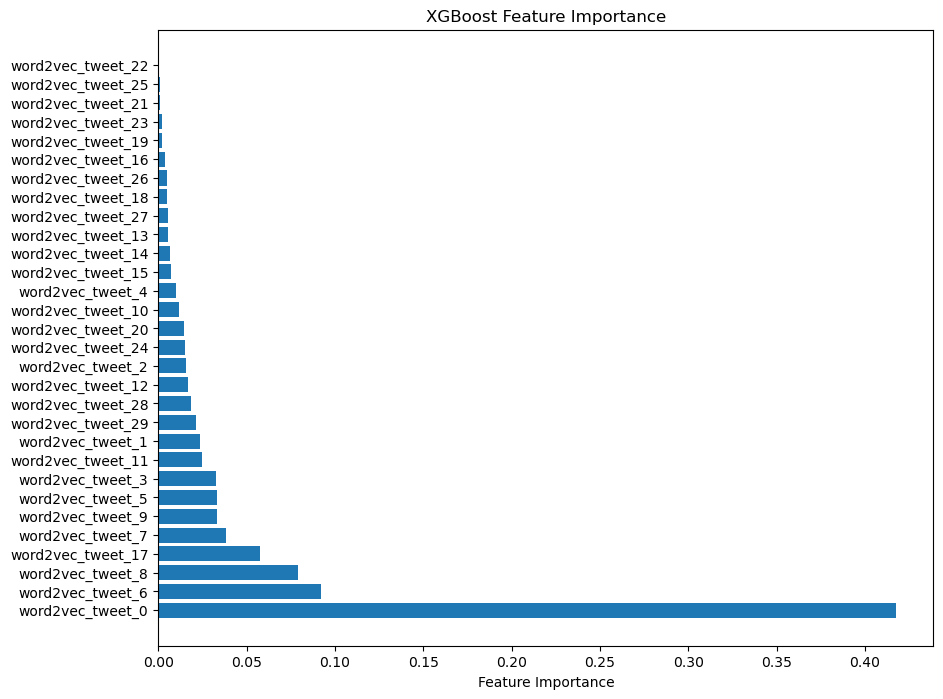

In [13]:
# Create a DataFrame to organize the results
feature_importance_xgb_df = pd.DataFrame({'Feature': all_feature_names[:len(feature_importances_xgb)], 'Importance': feature_importances_xgb})

# Sort the DataFrame by importance
feature_importance_xgb_df = feature_importance_xgb_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances for XGBoost
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_xgb_df['Feature'], feature_importance_xgb_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.show()

In [14]:
# Define the parameter grid for KNN
param_grid_knn = {
    'svd__n_components': [10, 20, 30, 40],  
    'knn__n_neighbors': [3,5,7,9]
}

# Create a pipeline with TruncatedSVD and KNN
pipeline_knn = Pipeline([
    ('svd', TruncatedSVD()),
    ('knn', KNeighborsRegressor())
])

# Initialize GridSearchCV
grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=tscv, scoring='neg_mean_squared_error')

# Fit the model with hyperparameter tuning
grid_search_knn.fit(X, y)

# Get the best parameters and the best estimator
best_params_knn = grid_search_knn.best_params_
best_estimator_knn = grid_search_knn.best_estimator_

# Print the best parameters
print("Best Parameters for KNN:", best_params_knn)

Best Parameters for KNN: {'knn__n_neighbors': 3, 'svd__n_components': 20}


In [15]:
# Initialize lists to store predictions for each fold
y_pred_knn = []
y_true_knn = [] 
feature_importances_knn_list = []
# Perform time series cross-validation
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Create separate pipelines for each model
    pipeline_knn = Pipeline([
        ('svd', TruncatedSVD(n_components=best_params_knn['svd__n_components'])),  
        ('knn', KNeighborsRegressor(n_neighbors=best_params_knn['knn__n_neighbors']))
    ])

    # Fit the model
    pipeline_knn.fit(X_train, y_train)

    # Predict for the current fold
    y_pred_knn_fold = pipeline_knn.predict(X_test)

    # Append the predictions to the lists
    y_pred_knn.extend(y_pred_knn_fold)
    y_true_knn.extend(y_test)  # Append true target values
    
    # As KNN doesn't have a direct method for feature importances, we can print the importance of each feature in each fold
    feature_importances_knn = np.zeros(X.shape[1])
    feature_importances_knn_list.append(feature_importances_knn)

# Convert the prediction lists to NumPy arrays
y_pred_knn = np.array(y_pred_knn)
y_true_knn = np.array(y_true_knn)

# Calculate MAE, MSE, and R2 for the Random Forest model
mae_knn = mean_absolute_error(y_true_knn, y_pred_knn)
mse_knn = mean_squared_error(y_true_knn, y_pred_knn)
r2_knn = r2_score(y_true_knn, y_pred_knn)

# Print the evaluation metrics
print("MAE (KNN):", mae_knn)
print("MSE (KNN):", mse_knn)
print("R2 Score (KNN):", r2_knn)

MAE (KNN): 0.048823733333333334
MSE (KNN): 0.0036638684177777788
R2 Score (KNN): 0.43321636121481155


KNN Feature Importance:
{'word2vec_tweet_0': 0.0, 'word2vec_tweet_1': 0.0, 'word2vec_tweet_2': 0.0, 'word2vec_tweet_3': 0.0, 'word2vec_tweet_4': 0.0, 'word2vec_tweet_5': 0.0, 'word2vec_tweet_6': 0.0, 'word2vec_tweet_7': 0.0, 'word2vec_tweet_8': 0.0, 'word2vec_tweet_9': 0.0, 'word2vec_tweet_10': 0.0, 'word2vec_tweet_11': 0.0, 'word2vec_tweet_12': 0.0, 'word2vec_tweet_13': 0.0, 'word2vec_tweet_14': 0.0, 'word2vec_tweet_15': 0.0, 'word2vec_tweet_16': 0.0, 'word2vec_tweet_17': 0.0, 'word2vec_tweet_18': 0.0, 'word2vec_tweet_19': 0.0, 'word2vec_tweet_20': 0.0, 'word2vec_tweet_21': 0.0, 'word2vec_tweet_22': 0.0, 'word2vec_tweet_23': 0.0, 'word2vec_tweet_24': 0.0, 'word2vec_tweet_25': 0.0, 'word2vec_tweet_26': 0.0, 'word2vec_tweet_27': 0.0, 'word2vec_tweet_28': 0.0, 'word2vec_tweet_29': 0.0, 'word2vec_tweet_30': 0.0, 'word2vec_tweet_31': 0.0, 'word2vec_tweet_32': 0.0, 'word2vec_tweet_33': 0.0, 'word2vec_tweet_34': 0.0, 'word2vec_tweet_35': 0.0, 'word2vec_tweet_36': 0.0, 'word2vec_tweet_37': 0.

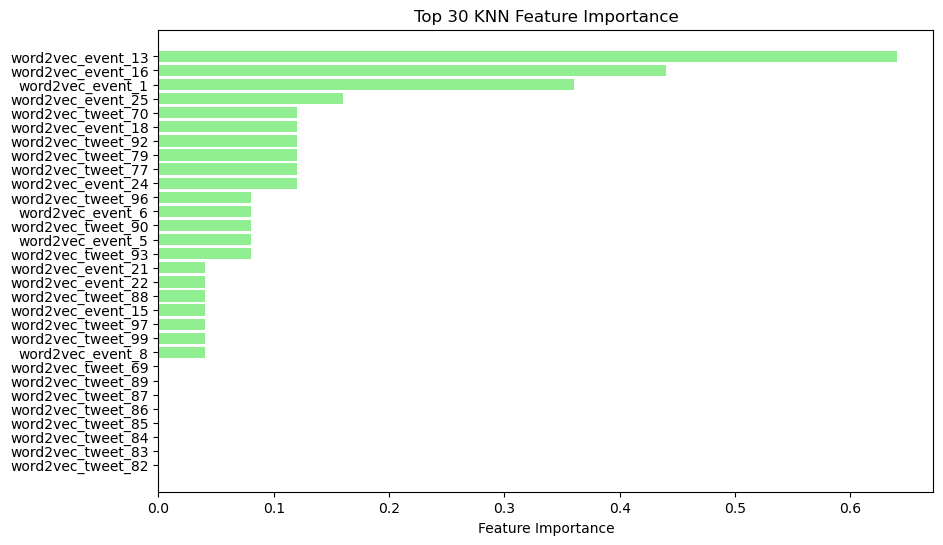

In [20]:
# Perform time series cross-validation for KNN
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Create a new instance of the KNN pipeline for each iteration
    pipeline_knn = clone(best_estimator_knn)

    # Fit the KNN model
    pipeline_knn.fit(X_train, y_train)

    # Apply TruncatedSVD to the test data
    X_test_transformed = pipeline_knn.named_steps['svd'].transform(X_test)

    # Get the indices of the nearest neighbors for each data point
    _, indices = pipeline_knn.named_steps['knn'].kneighbors(X_test_transformed)

    # Create an array to store the contribution of each feature
    feature_contributions = np.zeros(X_train.shape[1])

    # Accumulate the contribution of each feature based on the neighbors
    for neighbor_indices in indices:
        # Use try-except to handle cases where the index is out of bounds
        for index in neighbor_indices:
            try:
                feature_contributions[index] += 1
            except IndexError:
                pass

    # Normalize the contributions by the number of neighbors
    feature_importance_knn = feature_contributions / len(indices)

# Print or visualize the feature importances
print("KNN Feature Importance:")
print(dict(zip(all_feature_names, feature_importance_knn)))

# Bar chart for KNN Feature Importance
plt.figure(figsize=(10, 6))
top_knn_features_indices = np.argsort(feature_importance_knn)[-30:]
top_knn_features = [all_feature_names[i] for i in top_knn_features_indices]
top_knn_importance = feature_importance_knn[top_knn_features_indices]
plt.barh(top_knn_features, top_knn_importance, color='lightgreen')
plt.xlabel('Feature Importance')
plt.title('Top 30 KNN Feature Importance')
plt.show()

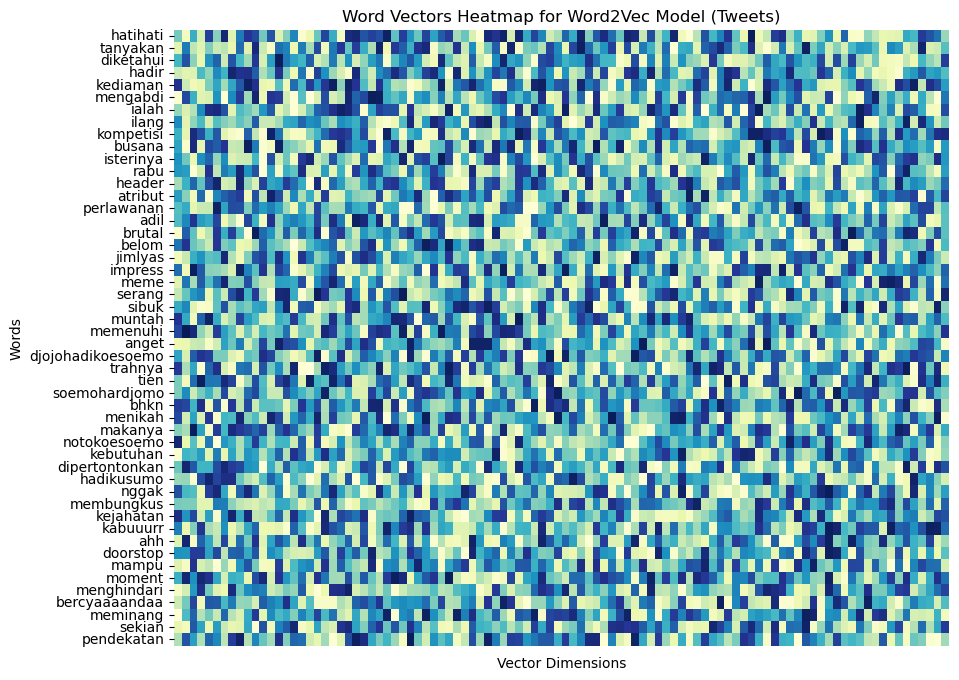

In [21]:
def plot_word_vectors_heatmap(word2vec_model, vocab, top_n=50):
    # Get the most frequent words based on their counts in the model
    sorted_vocab = sorted(vocab, key=lambda word: word2vec_model.wv.key_to_index[word], reverse=True)[:top_n]

    # Extract word vectors for the most frequent words
    word_vectors = [word2vec_model.wv.get_vector(word) for word in sorted_vocab]

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(word_vectors, cmap="YlGnBu", xticklabels=False, yticklabels=sorted_vocab, cbar=False)
    plt.title("Word Vectors Heatmap for Word2Vec Model (Tweets)")
    plt.xlabel("Vector Dimensions")
    plt.ylabel("Words")
    plt.show()

# Assuming you have the vocabulary (list of words) from the Word2Vec model
vocab = list(word2vec_model_tweets.wv.index_to_key)
plot_word_vectors_heatmap(word2vec_model_tweets, vocab, top_n=50)

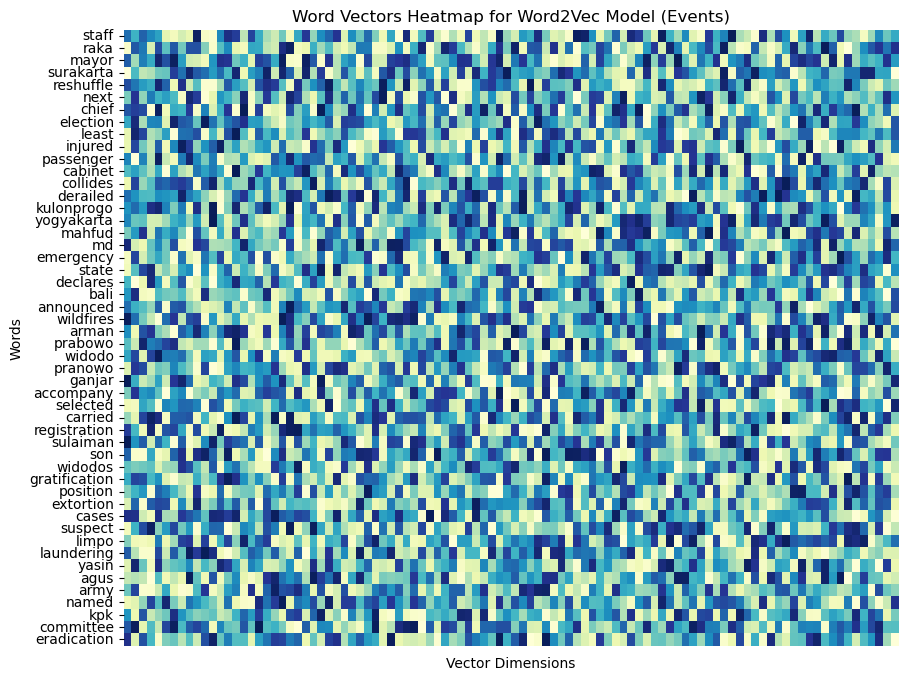

In [22]:
def plot_word_vectors_heatmap_event(word2vec_model, vocab, top_n=50):
    # Get the most frequent words based on their counts in the model
    sorted_vocab = sorted(vocab, key=lambda word: word2vec_model.wv.key_to_index[word], reverse=True)[:top_n]

    # Extract word vectors for the most frequent words
    word_vectors = [word2vec_model.wv.get_vector(word) for word in sorted_vocab]

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(word_vectors, cmap="YlGnBu", xticklabels=False, yticklabels=sorted_vocab, cbar=False)
    plt.title("Word Vectors Heatmap for Word2Vec Model (Events)")
    plt.xlabel("Vector Dimensions")
    plt.ylabel("Words")
    plt.show()

# Assuming you have the vocabulary (list of words) from the Word2Vec model for events
vocab_event = list(word2vec_model_events.wv.index_to_key)
plot_word_vectors_heatmap_event(word2vec_model_events, vocab_event, top_n=50)

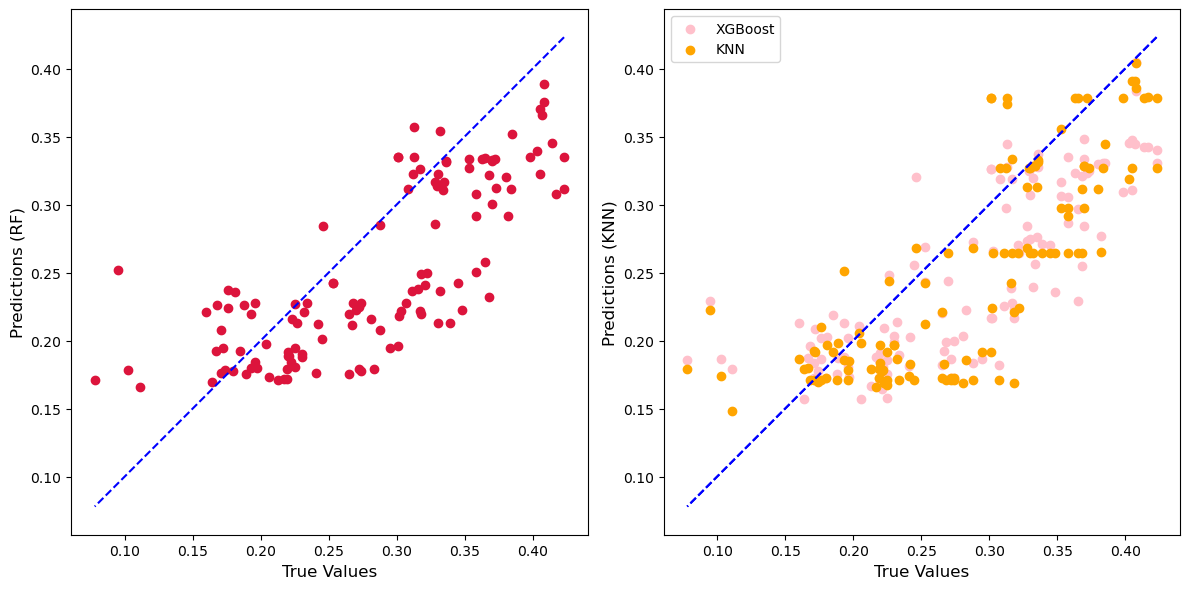

In [23]:
# Create a scatter plot for each model's predictions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

# Plot True Values vs. Predictions for RandomForestRegressor
plt.scatter(y_true, y_pred_rf, c='crimson', label='RandomForestRegressor')
p1 = max(max(y_pred_rf), max(y_true))
p2 = min(min(y_pred_rf), min(y_true))
plt.plot([p1, p2], [p1, p2], 'b--')
plt.xlabel('True Values', fontsize=12)
plt.ylabel('Predictions (RF)', fontsize=12)
plt.axis('equal')


# Create another scatter plot for XGB
plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred_xgb, c='pink', label='XGBoost')
p1 = max(max(y_pred_xgb), max(y_true))
p2 = min(min(y_pred_xgb), min(y_true))
plt.plot([p1, p2], [p1, p2], 'b--')
plt.xlabel('True Values', fontsize=12)
plt.ylabel('Predictions (XGB)', fontsize=12)
plt.axis('equal')

# Create another scatter plot for KNN
plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred_knn, c='orange', label='KNN')
p1 = max(max(y_pred_knn), max(y_true))
p2 = min(min(y_pred_knn), min(y_true))
plt.plot([p1, p2], [p1, p2], 'b--')
plt.xlabel('True Values', fontsize=12)
plt.ylabel('Predictions (KNN)', fontsize=12)
plt.axis('equal')

plt.tight_layout()

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

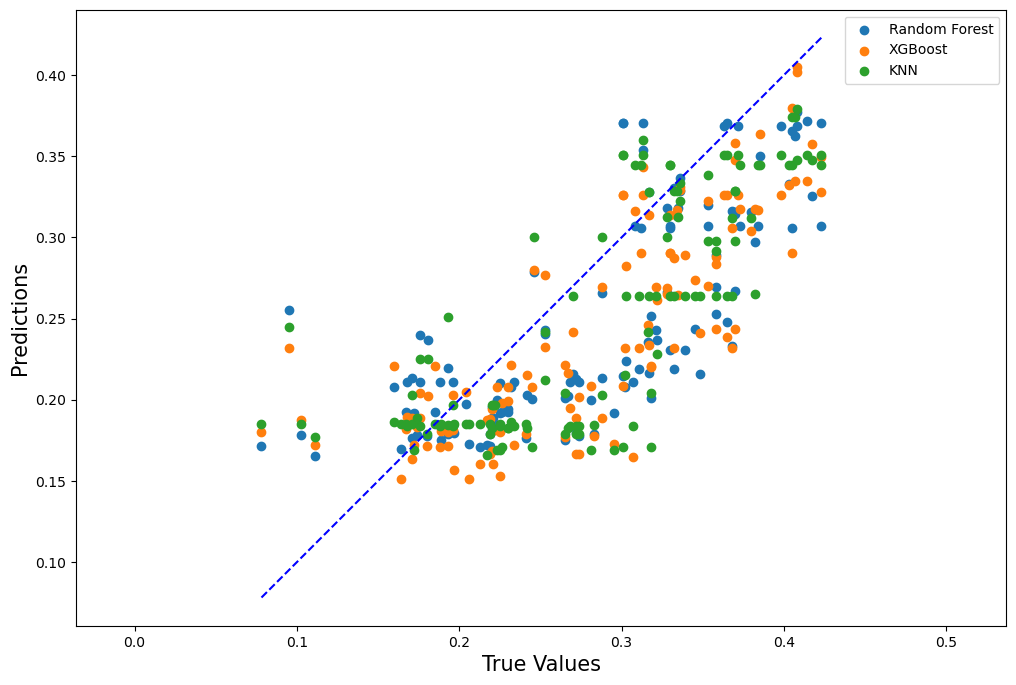

In [28]:
# Assuming you have predictions from Random Forest (y_pred_rf), XGBoost (y_pred_xgb), and LightGBM (y_pred_lgbm)
predictions = [y_pred_rf, y_pred_xgb, y_pred_knn]
model_names = ['Random Forest', 'XGBoost','KNN']

# Create a scatter plot for each model's predictions
plt.figure(figsize=(12, 8))

for i, model_pred in enumerate(predictions):
    plt.scatter(y_true, model_pred, label=model_names[i])


# Calculate the axis limits to ensure the diagonal line is shown
p1 = max([max(y_true)] + [max(pred) for pred in predictions])
p2 = min([min(y_true)] + [min(pred) for pred in predictions])

# Plot the diagonal line
plt.plot([p1, p2], [p1, p2], 'b--')

# Add labels and legend
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.legend()

# Show the plot
plt.show()